fake note detection

In [3]:
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2
import numpy as np
import seaborn as sns
from sklearn.metrics import f1_score
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau
import pickle

In [4]:
def process_jpg_image(img):
  img = tf.convert_to_tensor(img[:,:,:3])
  img = np.expand_dims(img, axis = 0)
  img = tf.image.resize(img,[224,224])
  img = (img/255.0)
  return img

def show_confusion_matrix(cm, labels):
    '''
    plots heatmap of confusion matrix'''
    plt.figure(figsize=(15, 10))
    sns.heatmap(cm, xticklabels=labels, yticklabels=labels, 
              annot=True, fmt='g')
    plt.xlabel('Prediction')
    plt.ylabel('Label')
    plt.show()

In [5]:
# Load all the images. training folder is split 20% as validation set and testing folder is loaded as test dataset.

train_dir = r"C:\Users\nandi\OneDrive\Desktop\Dhrma\dataset"
preprocess_input = tf.keras.applications.vgg16.preprocess_input
TARGET_SIZE = 224
BATCH_SIZE = 64


train_datagen = ImageDataGenerator(validation_split=0.2,
                                   rescale=1./255)


train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size=BATCH_SIZE,
                                                    class_mode='categorical',
                                                    subset="training",
                                                    shuffle = True,
                                                    target_size=(TARGET_SIZE,TARGET_SIZE))

validation_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size=BATCH_SIZE,
                                                    class_mode='categorical',
                                                    subset="validation", 
                                                    shuffle = False,
                                                    target_size=(TARGET_SIZE,TARGET_SIZE))

Found 500 images belonging to 2 classes.
Found 125 images belonging to 2 classes.


In [6]:
# Print all the classes

train_generator.class_indices

{'fake': 0, 'real': 1}

In [7]:
for image_batch, labels_batch in train_generator:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(64, 224, 224, 3)
(64, 2)


In [8]:

from tensorflow.keras.applications.vgg16 import VGG16


base_model = VGG16(weights='imagenet', input_shape=(TARGET_SIZE, TARGET_SIZE, 3), include_top=False)
base_model.trainable = False

# Adding a model on top

inputs = tf.keras.Input(shape=(TARGET_SIZE, TARGET_SIZE, 3))

x = base_model.output
x = tf.keras.layers.Dropout(0.25)(x)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.25)(x)
x = tf.keras.layers.Dense(16, activation='relu')(x)
x = tf.keras.layers.Dropout(0.25)(x)
output = tf.keras.layers.Dense(2, activation='softmax')(x)

vgg = tf.keras.Model(inputs=base_model.input, outputs=output)

In [9]:
vgg.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 512)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │              

 Total params: 14,722,930 (56.16 MB)

 Trainable params: 8,242 (32.20 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [10]:
opt = tf.keras.optimizers.Adam()
cce = tf.keras.losses.BinaryCrossentropy()
vgg.compile(optimizer=opt, loss=cce, metrics= ['acc'])

In [11]:
checkpoint_filepath = 'C:/Users/nandi/OneDrive/Desktop/Dhrma/best_model.weights.h5'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=5, min_lr=0.001)

In [12]:
EPOCHS = 50
NUM_STEPS = int(train_generator.samples / BATCH_SIZE)  # Convert to int
VAL_NUM_STEPS = int(validation_generator.samples / BATCH_SIZE)  # Convert to int

model = vgg.fit(
    train_generator, 
    epochs=EPOCHS, 
    steps_per_epoch=NUM_STEPS, 
    validation_steps=VAL_NUM_STEPS, 
    validation_data=validation_generator, 
    callbacks=[reduce_lr]
)

C:\Users\nandi\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 120s 16s/step - acc: 0.5970 - loss: 0.6771 - val_acc: 0.4062 - val_loss: 0.7093 - learning_rate: 0.0010
Epoch 2/50
1/7 ━━━━━━━━━━━━━━━━━━━━ 54s 9s/step - acc: 0.5625 - loss: 0.6482

C:\Users\nandi\anaconda3\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


7/7 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step - acc: 0.5625 - loss: 0.6482 - val_acc: 1.0000 - val_loss: 0.5054 - learning_rate: 0.0010
Epoch 3/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 113s 16s/step - acc: 0.6455 - loss: 0.6290 - learning_rate: 0.0010
Epoch 4/50


C:\Users\nandi\anaconda3\Lib\site-packages\keras\src\callbacks\callback_list.py:151: UserWarning: Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: acc,loss,learning_rate.
  callback.on_epoch_end(epoch, logs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 19s 2s/step - acc: 0.5962 - loss: 0.6449 - val_acc: 0.8438 - val_loss: 0.6045 - learning_rate: 0.0010
Epoch 5/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 98s 14s/step - acc: 0.7277 - loss: 0.6052 - val_acc: 1.0000 - val_loss: 0.4324 - learning_rate: 0.0010
Epoch 6/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 11s 66ms/step - acc: 0.8125 - loss: 0.5398 - learning_rate: 0.0010
Epoch 7/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 107s 15s/step - acc: 0.7562 - loss: 0.5700 - val_acc: 0.7969 - val_loss: 0.5764 - learning_rate: 0.0010
Epoch 8/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - acc: 0.8438 - loss: 0.5450 - val_acc: 1.0000 - val_loss: 0.3237 - learning_rate: 0.0010
Epoch 9/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 92s 12s/step - acc: 0.7993 - loss: 0.5091 - learning_rate: 0.0010
Epoch 10/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 25s 2s/step - acc: 0.7969 - loss: 0.5056 - val_acc: 0.7969 - val_loss: 0.5511 - learning_rate: 0.0010
Epoch 11/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 97s 13s/step - acc: 0.8326 - loss: 0.4688 - val_acc: 1.0000 - val_loss: 0.2

In [13]:
# Save the model to disk

#vgg.save("vgg_model_2.h5")
pickle.dump(vgg, open('vgg-modelDhrma.pkl','wb'))

In [14]:
pick_insert = open('vggDhrma.pickle','wb')
pickle.dump(vgg, pick_insert)
pick_insert.close()

In [15]:

acc = model.history['acc']
val_acc = model.history['val_acc']

loss = model.history['loss']
val_loss = model.history['val_loss']

epochs_range = range(EPOCHS)

# plt.figure(figsize=(16, 8))
# plt.subplot(1, 2, 1)
# plt.plot(epochs_range, acc, label='Training Accuracy')
# plt.plot(epochs_range, val_acc, label='Validation Accuracy')
# plt.legend(loc='lower right')
# plt.title('Training and Validation Accuracy')

# plt.subplot(1, 2, 2)
# plt.plot(epochs_range, loss, label='Training Loss')
# plt.plot(epochs_range, val_loss, label='Validation Loss')
# plt.legend(loc='upper right')
# plt.title('Training and Validation Loss')
# plt.show()

In [16]:
class_names = list(train_generator.class_indices.items())
print(class_names)

[('fake', 0), ('real', 1)]


In [17]:
test_image_path = r"C:\Users\nandi\OneDrive\Desktop\Dhrma\dataset\fake\50 Rupee Note....jpg"

In [18]:
test_image_read_1 = cv2.imread(test_image_path)

if test_image_read_1 is None:
    raise ValueError("Error: Image is None. Check file path or format.")

test_image_1 = process_jpg_image(test_image_read_1)
prediction_1 = vgg.predict(test_image_1)

print(f'Dimensions of image used for prediction: {test_image_1.shape}')

prediction = int(np.argmax(prediction_1))
print(f"Prediction is: {class_names[prediction]}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 826ms/step
Dimensions of image used for prediction: (1, 224, 224, 3)
Prediction is: ('fake', 0)


In [19]:
# Get the labels of all the images
true_labels = validation_generator.labels
# Making the predictions of all the validation images
all_predictions = vgg.predict(validation_generator)

2/2 ━━━━━━━━━━━━━━━━━━━━ 21s 10s/step


In [20]:
preds = []
for items in all_predictions:
    preds.append(np.argmax(items))

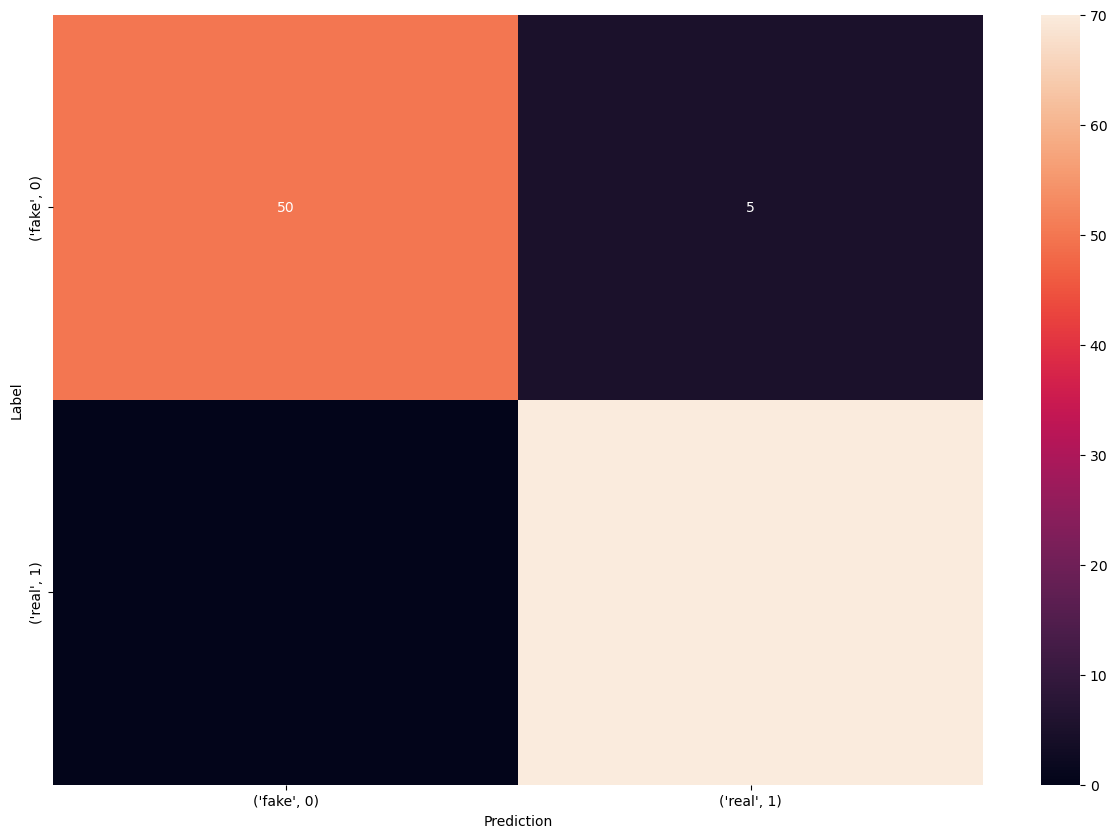

In [21]:
# plot the confusion matrix

confusion_mat = tf.math.confusion_matrix(
    true_labels, preds, dtype=tf.dtypes.int32)

show_confusion_matrix(confusion_mat, class_names)

In [22]:
f1 = f1_score(true_labels, preds, average='weighted')
print(f"F1 score of the model is", f1)

F1 score of the model is 0.9597372742200329


In [23]:
from sklearn.metrics import accuracy_score

# Calculate accuracy
accuracy = accuracy_score(true_labels, preds)
print(f"Model Accuracy: {accuracy * 100:.2f}%")


Model Accuracy: 96.00%
